# Google News Scraping
In this notebook you can find the necessary code to retrieve articles for given keywords on a date range

In [17]:
from newsplease import NewsPlease
from googlesearch import search, get_tbs
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import logging

## Date interval

In [18]:
start = "2019-01-01"
end   = "2022-06-30"

## Stock prices

In [19]:
stocks = ["BTC-USD"]
keywords = {"BTC-USD" : ["Bitcoin", "Cryptocurrency"] }

In [20]:
df = yf.download(stocks, 
                     #period = "1Y",
                      start= start, 
                      end= end, 
                      progress=False)
df["Close"].tail()

Date
2022-06-25    21502.337891
2022-06-26    21027.294922
2022-06-27    20735.478516
2022-06-28    20280.634766
2022-06-29    20104.023438
Name: Close, dtype: float64

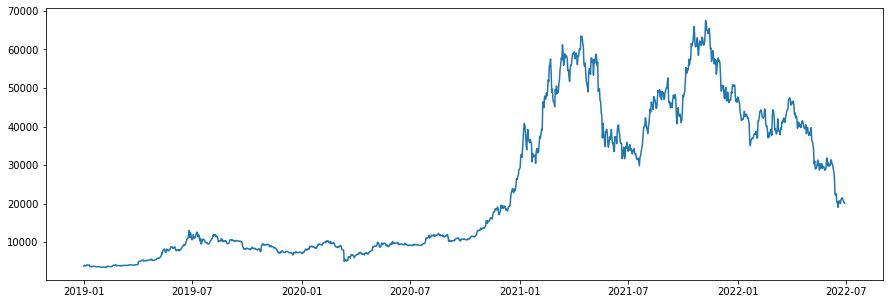

In [21]:
fig, ax = plt.subplots(figsize=(15,5))
plt.plot(df["Close"])

# Google news

In [22]:
start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end, "%Y-%m-%d")


In [23]:
tbs = get_tbs(start_date,end_date)
print(tbs)

cdr:1,cd_min:01/01/2019,cd_max:06/30/2022


In [24]:
def find_urls(search_term, tbs, number):
    results =  search(search_term ,lang = "en",tbs = tbs, country = "usa", stop=number)
    urls = []
    for url in results:
        urls.append(url)
    return urls

In [25]:
def detect_empty_articles(articles):
    empty = []
    for url in articles:
        article = articles.get(url)
        if (article.maintext == None and article.text == None):
            empty.append(url)
    for k in empty:
        articles.pop(k)
    return empty, articles

In [26]:
def download_articles(search_term, n_articles, start, end = None):
    start_date = datetime.datetime.strptime(start, "%Y-%m-%d")
    end_date = start_date if end is None else datetime.datetime.strptime(end, "%Y-%m-%d")
    tbs = get_tbs(start_date,end_date)

    urls = find_urls(search_term, tbs, 10)
    valid_articles = []
    while (len(valid_articles) < n_articles and len(urls) > 0):
        articles_left = 5 - len(valid_articles)
        articles = NewsPlease.from_urls(urls[:articles_left], timeout=10)
        empty, articles = detect_empty_articles(articles)
        for new in articles:
            valid_articles.append(articles.get(new))
        urls = urls[articles_left:]
    #print("valid_articles", len(valid_articles))
    return {"search_term": search_term ,"start": start, "end": start if end is None else end,"articles" : valid_articles}

    

In [27]:
def prepare_entries(articles_dict):
    entries = []
    articles, search_term, start = articles_dict["articles"], articles_dict["search_term"], articles_dict["start"]
    for art in articles:
        text = art.maintext if art.maintext != None else art.text
        entry = {
            "date_google": start,
            "date_article": art.date_publish.strftime("%Y-%m-%d") if art.date_publish is not None else None,
            "search_term": search_term,
            "authors": ",".join(art.authors) if art.authors is not None else None,
            "source_domain": art.source_domain,
            "title": art.title,
            "description": art.description,
            "url": art.url,
            "maintext": text
        }
        entries.append(entry)
    # print("Entries: ", len(entries))
    return entries

In [28]:
def search_articles_for_each_day(search_term, start, end):
    dates = pd.date_range(start, end).format(formatter=lambda x: x.strftime('%Y-%m-%d'))
    all_entries = []
    errors = []
    for date in dates:
        try:
            articles_dict = download_articles(search_term, 5, date)
            print("New Article! Total: {} Date: {}".format(len(all_entries), date))
            entries = prepare_entries(articles_dict)
            all_entries.extend(entries)
        except Exception as ex:
            errors.append({"search_term" : search_term, "date" : date})
            logging.exception("Could not retrieve articles with search_term = {} for date {}".format(search_term, date))
    df = pd.DataFrame(all_entries)
    errors_df = pd.DataFrame(errors)
    return df, errors_df

In [29]:
def search_articles_for_keywords(keywords, start, end):
    for k in keywords:
        search_term = " | ".join(keywords.get(k))
        df, errors = search_articles_for_each_day(search_term, start, end)
        df.to_csv("./dataset/{} start:{} end:{}.csv".format(search_term,start,end))
        errors.to_csv("./dataset/Errors- {} start:{} end:{}.csv".format(search_term,start,end))

In [ ]:
search_articles_for_keywords(keywords, start_date, end_date)